# Chap.09 ロジスティック回帰モデル（多値分類）  

In [17]:
# ライブラリの準備
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'IPAexgothic'
# plt.style.use('ggplot')
plt.style.use('seaborn-darkgrid')
%matplotlib inline

データ読み込み

In [18]:
# 学習用データ準備
from sklearn.datasets import load_iris
iris = load_iris()
x_org, y_org = iris.data, iris.target

# 入力データに関しては、sepal length(0)とpetal length(2)のみ抽出
x_select = x_org[:, [0, 2]]
print('元データ', x_select.shape, y_org.shape)

元データ (150, 2) (150,)


学習データの散布図

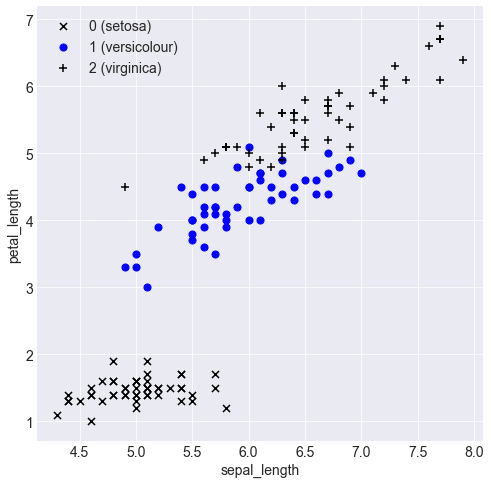

In [19]:
# 散布図の表示
x_t0 = x_select[y_org == 0]
x_t1 = x_select[y_org == 1]
x_t2 = x_select[y_org == 2]
plt.figure(figsize=(8, 8))
plt.scatter(x_t0[:, 0], x_t0[:, 1], marker='x',
            c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:, 0], x_t1[:, 1], marker='o',
            c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:, 0], x_t2[:, 1], marker='+',
            c='k', s=50, label='2 (virginica)')
plt.xlabel('sepal_length', fontsize=14)
plt.ylabel('petal_length', fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14)
plt.show()

データの前処理

In [20]:
# ダミー変数を追加
x_all = np.insert(x_select, 0, 1.0, axis=1)

In [21]:
# yをOne-hot-Vector化
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, categories='auto')
y_work = np.c_[y_org]
y_all_one = ohe.fit_transform(y_work)
print('オリジナル', y_org.shape)
print('２次元化', y_work.shape)
print('One Hot Vector化後', y_all_one.shape)

オリジナル (150,)
２次元化 (150, 1)
One Hot Vector化後 (150, 3)


In [22]:
# 学習データ、検証データに分割
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, y_train_one, y_test_one = train_test_split(
    x_all, y_org, y_all_one, train_size=75, test_size=75, random_state=123)
print(x_train.shape, x_test.shape, 
      y_train.shape, y_test.shape,
      y_train_one.shape, y_test_one.shape)

(75, 3) (75, 3) (75,) (75,) (75, 3) (75, 3)


In [23]:
print('入力データ(x)')
print(x_train[:5,:])

入力データ(x)
[[1.  6.3 4.7]
 [1.  7.  4.7]
 [1.  5.  1.6]
 [1.  6.4 5.6]
 [1.  6.3 5. ]]


In [24]:
print('正解データ(y)')
print(y_train[:5])

正解データ(y)
[1 1 0 2 2]


In [25]:
print('正解データ (One Hot Vector化後)')
print(y_train_one[:5,:])

正解データ (One Hot Vector化後)
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


学習用変数の設定

In [26]:
# 学習対象の選択
x, yt = x_train, y_train_one

予測関数

In [27]:
# softmax関数 (9.7.3)
def softmax(x):
    x = x.T
    x_max = x.max(axis=0)
    x = x - x_max
    w = np.exp(x)
    return (w / w.sum(axis=0)).T

In [28]:
# 予測値の計算 (9.7.1, 9.7.2)
def pred(x, W):
    return softmax(x @ W)

評価

In [29]:
# 交差エントロピー関数)(9.5.1)
def cross_entropy(yt, yp):
    return -np.mean(np.sum(yt * np.log(yp), axis=1))

In [30]:
# モデルの評価を行う関数
from sklearn.metrics import accuracy_score


def evaluate(x_test, y_test, y_test_one, W):

    # 予測値の計算(確率値)
    yp_test_one = pred(x_test, W)

    # 確率値から予測クラス(0, 1, 2)を導出
    yp_test = np.argmax(yp_test_one, axis=1)

    # 損失関数値の計算
    loss = cross_entropy(y_test_one, yp_test_one)

    # 精度の算出
    score = accuracy_score(y_test, yp_test)
    return loss, score

初期化処理

In [31]:
# 初期化処理

# 標本数
M = x.shape[0]
# 入力次元数(ダミー変数を含む
D = x.shape[1]
# 分類先クラス数
N = yt.shape[1]

# 繰り返し回数
iters = 10000

# 学習率
alpha = 0.01

# 重み行列の初期設定(すべて1)
W = np.ones((D, N))

# 評価結果記録用
history = np.zeros((0, 3))

メイン処理

In [32]:
#  メイン処理
for k in range(iters):

    # 予測値の計算 (9.7.1)　(9.7.2)
    yp = pred(x, W)

    # 誤差の計算 (9.7.4)
    yd = yp - yt

    # 重みの更新 (9.7.5)
    W = W - alpha * (x.T @ yd) / M

    if (k % 10 == 0):
        loss, score = evaluate(x_test, y_test, y_test_one, W)
        history = np.vstack((history,
                             np.array([k, loss, score])))
        print("epoch = %d loss = %f score = %f"
              % (k, loss, score))

epoch = 0 loss = 1.092628 score = 0.266667
epoch = 10 loss = 1.064035 score = 0.266667
epoch = 20 loss = 1.033466 score = 0.266667
epoch = 30 loss = 1.002645 score = 0.266667
epoch = 40 loss = 0.973510 score = 0.266667
epoch = 50 loss = 0.946309 score = 0.386667
epoch = 60 loss = 0.920978 score = 0.560000
epoch = 70 loss = 0.897402 score = 0.600000
epoch = 80 loss = 0.875452 score = 0.613333
epoch = 90 loss = 0.855005 score = 0.626667
epoch = 100 loss = 0.835942 score = 0.626667
epoch = 110 loss = 0.818152 score = 0.626667
epoch = 120 loss = 0.801532 score = 0.626667
epoch = 130 loss = 0.785986 score = 0.626667
epoch = 140 loss = 0.771424 score = 0.640000
epoch = 150 loss = 0.757767 score = 0.653333
epoch = 160 loss = 0.744941 score = 0.680000
epoch = 170 loss = 0.732877 score = 0.706667
epoch = 180 loss = 0.721513 score = 0.760000
epoch = 190 loss = 0.710795 score = 0.786667
epoch = 200 loss = 0.700670 score = 0.786667
epoch = 210 loss = 0.691092 score = 0.800000
epoch = 220 loss = 0.

結果の確認

In [33]:
#損失関数値と精度の確認
print('初期状態: 損失関数:%f 精度:%f'
      % (history[0, 1], history[0, 2]))
print('最終状態: 損失関数:%f 精度:%f'
      % (history[-1, 1], history[-1, 2]))

初期状態: 損失関数:1.092628 精度:0.266667
最終状態: 損失関数:0.197948 精度:0.960000


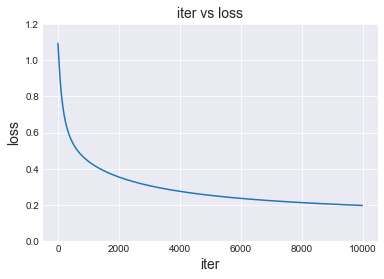

In [34]:
# 学習曲線の表示 (損失関数)
plt.plot(history[:, 0], history[:, 1])
plt.grid(True)
plt.ylim(0, 1.2)
plt.xlabel('iter', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.title('iter vs loss', fontsize=14)
plt.show()

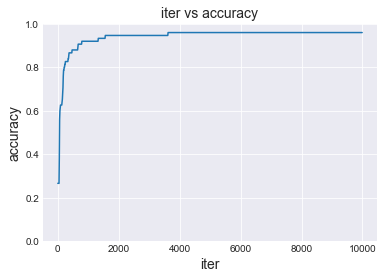

In [35]:
# 学習曲線の表示 (精度)
plt.plot(history[:, 0], history[:, 2])
plt.ylim(0, 1)
plt.grid(True)
plt.xlabel('iter', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('iter vs accuracy', fontsize=14)
plt.show()

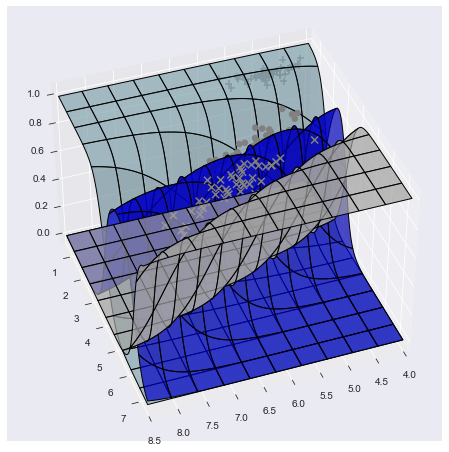

In [37]:
# 3次元表示
from mpl_toolkits.mplot3d import Axes3D

x1 = np.linspace(4, 8.5, 100)
x2 = np.linspace(0.5, 7.5, 100)
xx1, xx2 = np.meshgrid(x1, x2)
xxx = np.array([np.ones(xx1.ravel().shape),
                xx1.ravel(), xx2.ravel()]).T
pp = pred(xxx, W)
c0 = pp[:, 0].reshape(xx1.shape)
c1 = pp[:, 1].reshape(xx1.shape)
c2 = pp[:, 2].reshape(xx1.shape)
plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(xx1, xx2, c0, color='lightblue',
                edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.plot_surface(xx1, xx2, c1, color='blue',
                edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.plot_surface(xx1, xx2, c2, color='lightgrey',
                edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.scatter(x_t0[:, 0], x_t0[:, 1], 1, s=50, alpha=1, marker='+', c='gray')
ax.scatter(x_t1[:, 0], x_t1[:, 1], 1, s=30, alpha=1, marker='o', c='gray')
ax.scatter(x_t2[:, 0], x_t2[:, 1], 1, s=50, alpha=1, marker='x', c='gray')
ax.set_xlim(4, 8.5)
ax.set_ylim(0.5, 7.5)
ax.view_init(elev=40, azim=70)


In [38]:
# 評価
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# テストデータで予測値の計算
yp_test_one = pred(x_test, W)
yp_test = np.argmax(yp_test_one, axis=1)

#  精度の計算
score = accuracy_score(y_test, yp_test)
print('accuracy: %f' % score)

# 混同行列の表示
print(confusion_matrix(y_test, yp_test))
print(classification_report(y_test, yp_test))

accuracy: 0.960000
[[27  0  0]
 [ 0 20  0]
 [ 0  3 25]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.87      1.00      0.93        20
           2       1.00      0.89      0.94        28

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.97      0.96      0.96        75



計算式

$w_0 + w_1x + w_2y = 0$

$y = -\frac{1}{w_2}(w_1x + x_0)$

In [39]:
# 決定境界用の１次関数定義
def d_bound(x, i, W):
    W1 = W[:, [2, 0, 1]]
    W2 = W - W1
    w = W2[:, i]
    v = -1/w[2]*(w[1]*x + w[0])
    return v

In [40]:
# x, yの描画領域計算
x_min = x_select[:, 0].min()
x_max = x_select[:, 0].max()
y_min = x_select[:, 1].min()
y_max = x_select[:, 1].max()
x_bound = np.array([x_min, x_max])

In [41]:
# 決定境界のyの値を計算
y0_bound = d_bound(x_bound, 0, W)
y1_bound = d_bound(x_bound, 1, W)
y2_bound = d_bound(x_bound, 2, W)

# 結果確認
print(y0_bound)
print(y1_bound)
print(y2_bound)

[2.90696266 5.10075533]
[2.13912805 3.9149779 ]
[3.58457746 6.14720506]


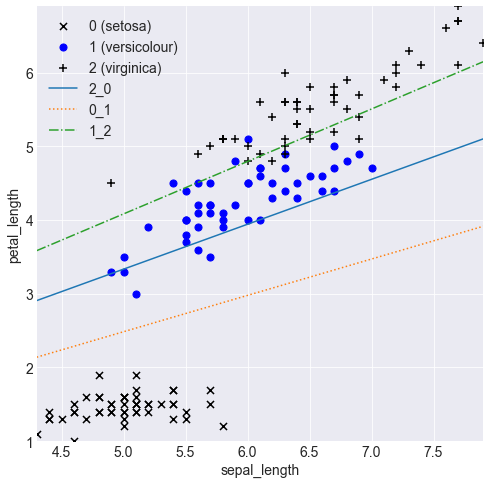

In [42]:
# 散布図と決定境界の標示

#グラフサイズ指定
plt.figure(figsize=(8, 8))

# 元データをグループ分け
x_t0 = x_select[y_org == 0]
x_t1 = x_select[y_org == 1]
x_t2 = x_select[y_org == 2]

# xとyの範囲を明示的に指定
plt.axis([x_min, x_max, y_min, y_max])

#  散布図の表示
plt.scatter(x_t0[:, 0], x_t0[:, 1], marker='x',
            c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:, 0], x_t1[:, 1], marker='o',
            c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:, 0], x_t2[:, 1], marker='+',
            c='k', s=50, label='2 (virginica)')

# 決定境界の標示
plt.plot(x_bound, y0_bound, label='2_0')
plt.plot(x_bound, y1_bound, linestyle=':', label='0_1')
plt.plot(x_bound, y2_bound, linestyle='-.', label='1_2')

# 軸ラベル設定
plt.xlabel('sepal_length', fontsize=14)
plt.ylabel('petal_length', fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14)
plt.show()